In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
%matplotlib inline

In [6]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':350,
        'noise':0.1,
        'train_size':0.7
        }

# Prepare Data

In [7]:
def get_dataloaders(layer):    
    dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=args['noise'], layer=layer)
    train_size = int(args['train_size'] * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])
    return train_loader, test_loader, train_dataset, test_dataset, dataset

In [8]:
layers = []
for layer in range(1,12):
    train_loader, test_loader, train_dataset, test_dataset, dataset = get_dataloaders(layer)
    layers.append({'layer' : layer,
                 'train loader' : train_loader, 
                 'test loader' : test_loader,
                 'train data' : train_dataset,
                 'test data' : test_dataset, 
                 'data' : dataset
                 })

# Design Models
(input size, output size, forward pass)

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = F.relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [10]:
n_samples = len(layers[0]['train data'])
_, sepc_size = layers[0]['data'].spec.shape
_, temp_size = layers[0]['data'].temp.shape

for layer in layers:
    layer['model'] = Net(input_size=sepc_size, output_size=temp_size)

# Training Loops

In [11]:
learning_rate = args['lr']
criterion = nn.MSELoss()
num_epochs = args['epochs']

In [12]:
best_losses = []
for layer in layers:
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {layer["layer"]}')
    optimizer = torch.optim.Adam(layer['model'].parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for temp_batch, spec_batch in train_loader:
            # forward pass and loss
            temp_pred = layer['model'](spec_batch)
            loss = criterion(temp_pred, temp_batch)

            # backward pass
            loss.backward()

            # update
            optimizer.step()

            # empty gradients
            optimizer.zero_grad()

        if (epoch+1) % int(num_epochs/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch+1

    best_losses.append(best_loss.item())
    print(f'best loss: {best_loss} in epoch {best_epoch}\n')

Layer 1
epoch: 35, loss = 31.867971420288086
epoch: 70, loss = 42.028587341308594
epoch: 105, loss = 17.821474075317383
epoch: 140, loss = 11.840102195739746
epoch: 175, loss = 6.563201904296875
epoch: 210, loss = 0.6893576979637146
epoch: 245, loss = 0.7706940174102783
epoch: 280, loss = 0.8742364645004272
epoch: 315, loss = 4.270092964172363
epoch: 350, loss = 0.946029543876648
best loss: 0.035085633397102356 in epoch 0

Layer 2
epoch: 35, loss = 16.86662483215332
epoch: 70, loss = 40.35740280151367
epoch: 105, loss = 2.875943899154663
epoch: 140, loss = 4.231400012969971
epoch: 175, loss = 13.373845100402832
epoch: 210, loss = 3.5837321281433105
epoch: 245, loss = 10.646951675415039
epoch: 280, loss = 0.6139277815818787
epoch: 315, loss = 1.2718313932418823
epoch: 350, loss = 1.29319429397583
best loss: 0.17328359186649323 in epoch 0

Layer 3
epoch: 35, loss = 21.279281616210938
epoch: 70, loss = 23.20022964477539
epoch: 105, loss = 11.630125999450684
epoch: 140, loss = 12.003799438

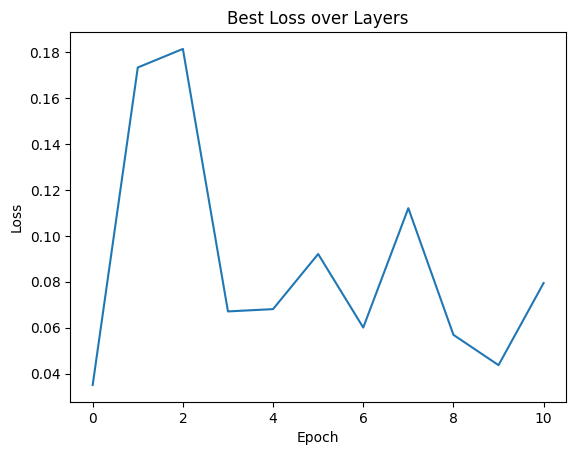

In [13]:
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [40]:
def make_predictions(spec_batch):
    predictions = []
    
    for layer in layers:
        pred = layer['model'](spec_batch)
        predictions.append(pred.detach().numpy())

    return np.array(predictions)

In [41]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual):
    actual_np = actual
    pred_np = pred


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    plt.title(f"Layer")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

[323.54282 302.3973  342.2532  ... 274.79782 364.11676 285.43033]
[306.585   307.13977 306.27994 306.4348  309.4167  305.08167 304.6053
 307.04855 309.07263 306.1567  304.1527 ]


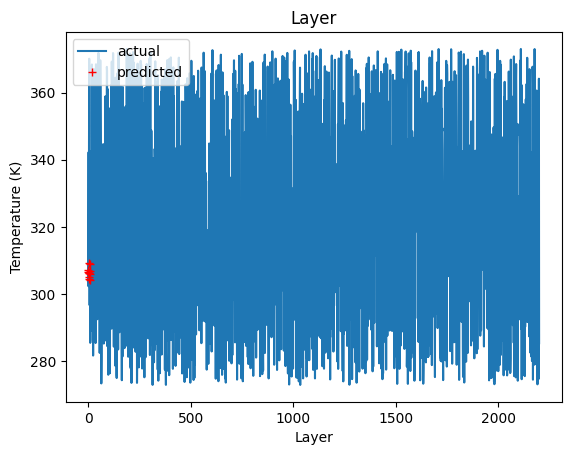

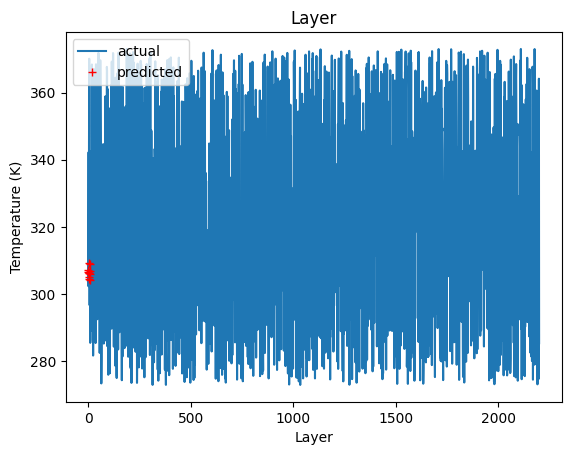

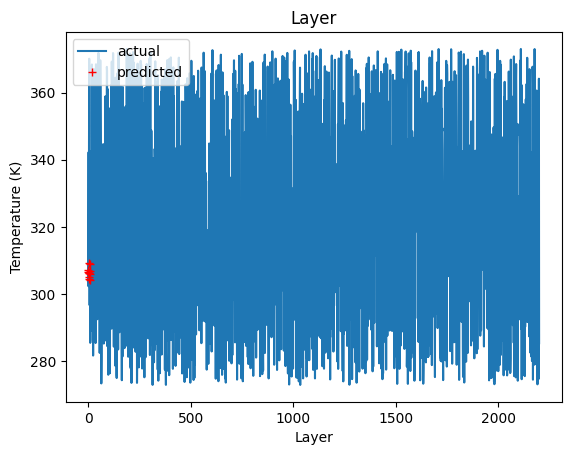

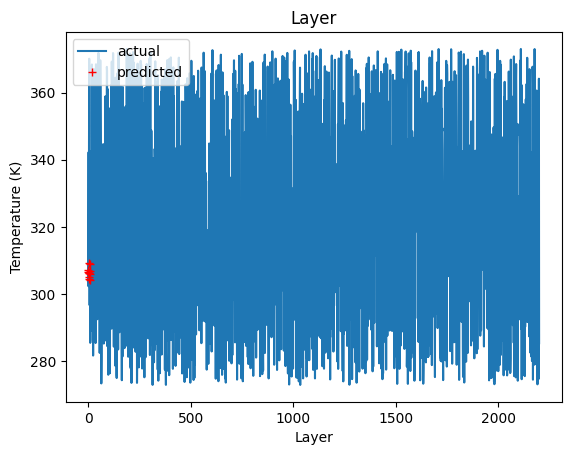

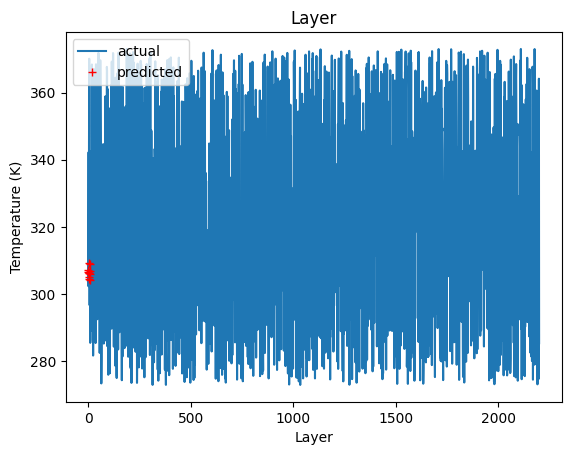

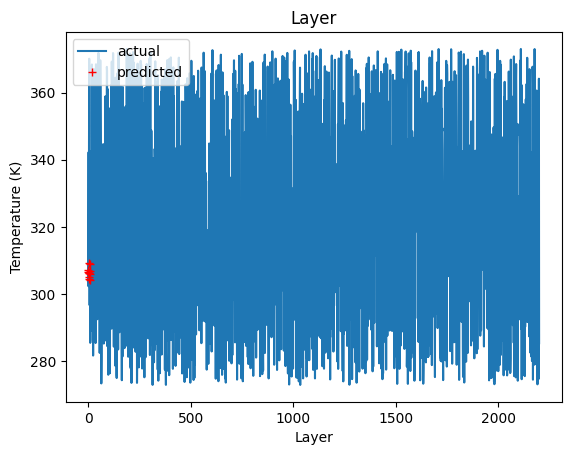

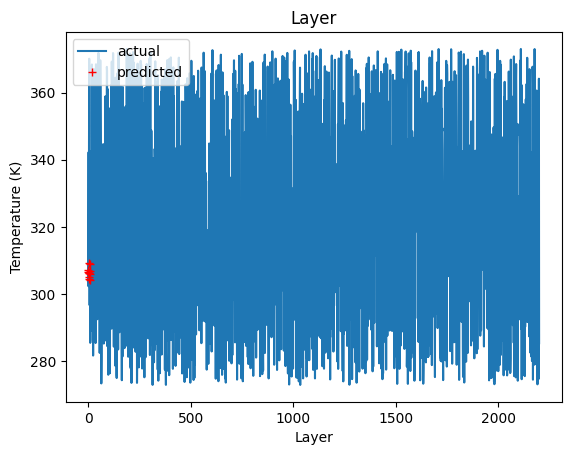

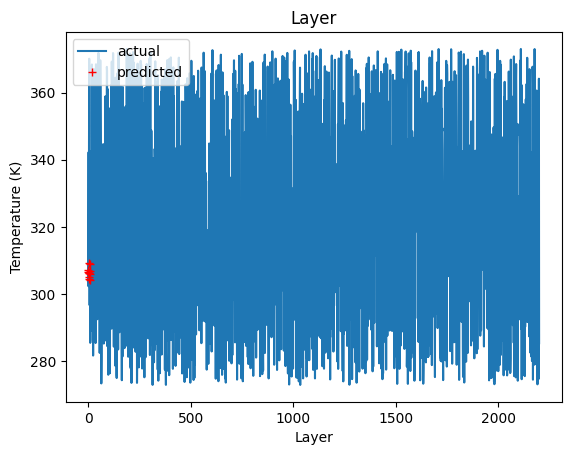

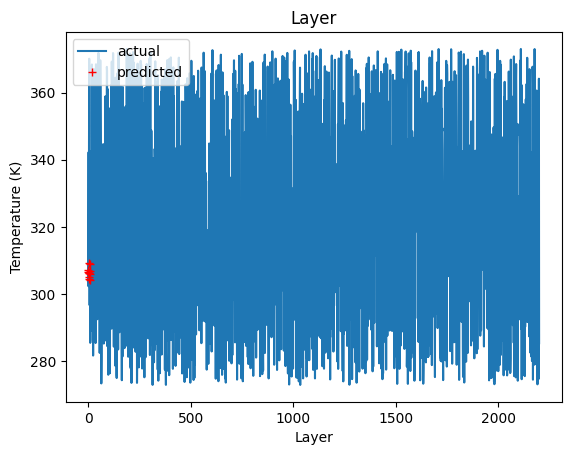

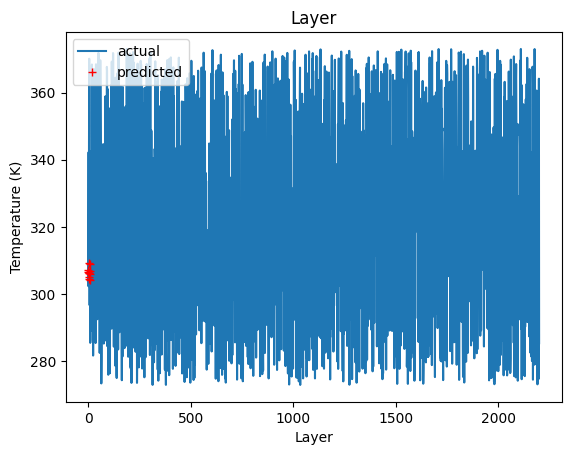

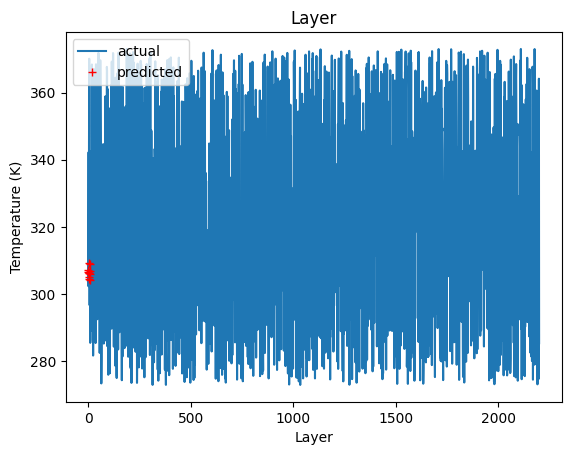

In [42]:
for test in layers:
    test_loader = test['test loader']
    total_loss = 0
    n_samples = 0
    total_batches = len(test_loader)
    current_batch = 0

    for layer in layers:
        with torch.no_grad():
            for temp_batch, spec_batch in test_loader:
                temp_pred = layer['model'](spec_batch)
                loss = criterion(temp_pred, temp_batch)
                total_loss += loss.item() * len(temp_batch)
                n_samples += len(temp_batch)
                current_batch += 1

    average_loss = total_loss/n_samples
    print(f"average loss: {average_loss}")